<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 02 - Exploratory Data Analysis
</div>

# **1. Import libraries**

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# **2. Read data**

- The data has been previously cleaned and saved into the file ../data/cleaned_data.csv.
- We read the data and saved it into a variable called `data` as a dataframe.

In [2]:
data = pd.read_csv('../data/cleaned_data.csv')
data

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers
0,Female,Excellent,0.0,3.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,...,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 70 to 74,1.60,67.13,26.22,Yes
1,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,No,...,No,Never smoked,Never used e-cigarettes in my entire life,No,Hispanic,Age 40 to 44,1.83,86.18,25.77,No
2,Female,Very good,0.0,0.0,Within past 2 years (1 year but less than 2 ye...,No,8.0,1 to 5,No,No,...,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 75 to 79,1.63,55.79,21.11,No
3,Female,Good,0.0,30.0,Within past year (anytime less than 12 months ...,No,7.0,None of them,No,No,...,No,Never smoked,Never used e-cigarettes in my entire life,No,"Black only, Non-Hispanic",Age 80 or older,1.75,72.57,23.63,No
4,Male,Good,12.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,No,No,...,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 75 to 79,1.73,65.77,22.05,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7652,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,...,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 60 to 64,1.63,79.38,30.04,Yes
7653,Male,Good,0.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,No,...,No,Current smoker - now smokes some days,Use them every day,Yes,"White only, Non-Hispanic",Age 30 to 34,1.83,65.77,19.67,Yes
7654,Male,Good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,None of them,No,Yes,...,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 70 to 74,1.78,90.72,28.70,Yes
7655,Female,Fair,5.0,5.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,...,No,Never smoked,Not at all (right now),No,Hispanic,Age 18 to 24,1.57,68.04,27.44,No


# **Overview**

Before conducting the analysis, let's examine the correlations between the variables in the dataset.

- **First**, we need to encode the data to compute the correlation matrix.


In [3]:
df = data.copy()
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = le.fit_transform(df[column].astype(str))
df.head(5)

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers
0,0,0,0.0,3.0,3,1,7.0,3,0,0,...,0,3,0,0,4,10,1.60,67.13,26.22,1
1,1,4,0.0,0.0,3,1,6.0,3,0,0,...,0,3,0,0,1,4,1.83,86.18,25.77,0
2,0,4,0.0,0.0,1,0,8.0,0,0,0,...,0,3,0,0,4,11,1.63,55.79,21.11,0
3,0,2,0.0,30.0,3,0,7.0,3,0,0,...,0,3,0,0,0,12,1.75,72.57,23.63,0
4,1,2,12.0,0.0,3,1,8.0,3,0,0,...,0,2,0,0,4,11,1.73,65.77,22.05,1


- **Secondly**, we calculate the correlation matrix using the `corr()` function and visualize it using a **heatmap** chart.

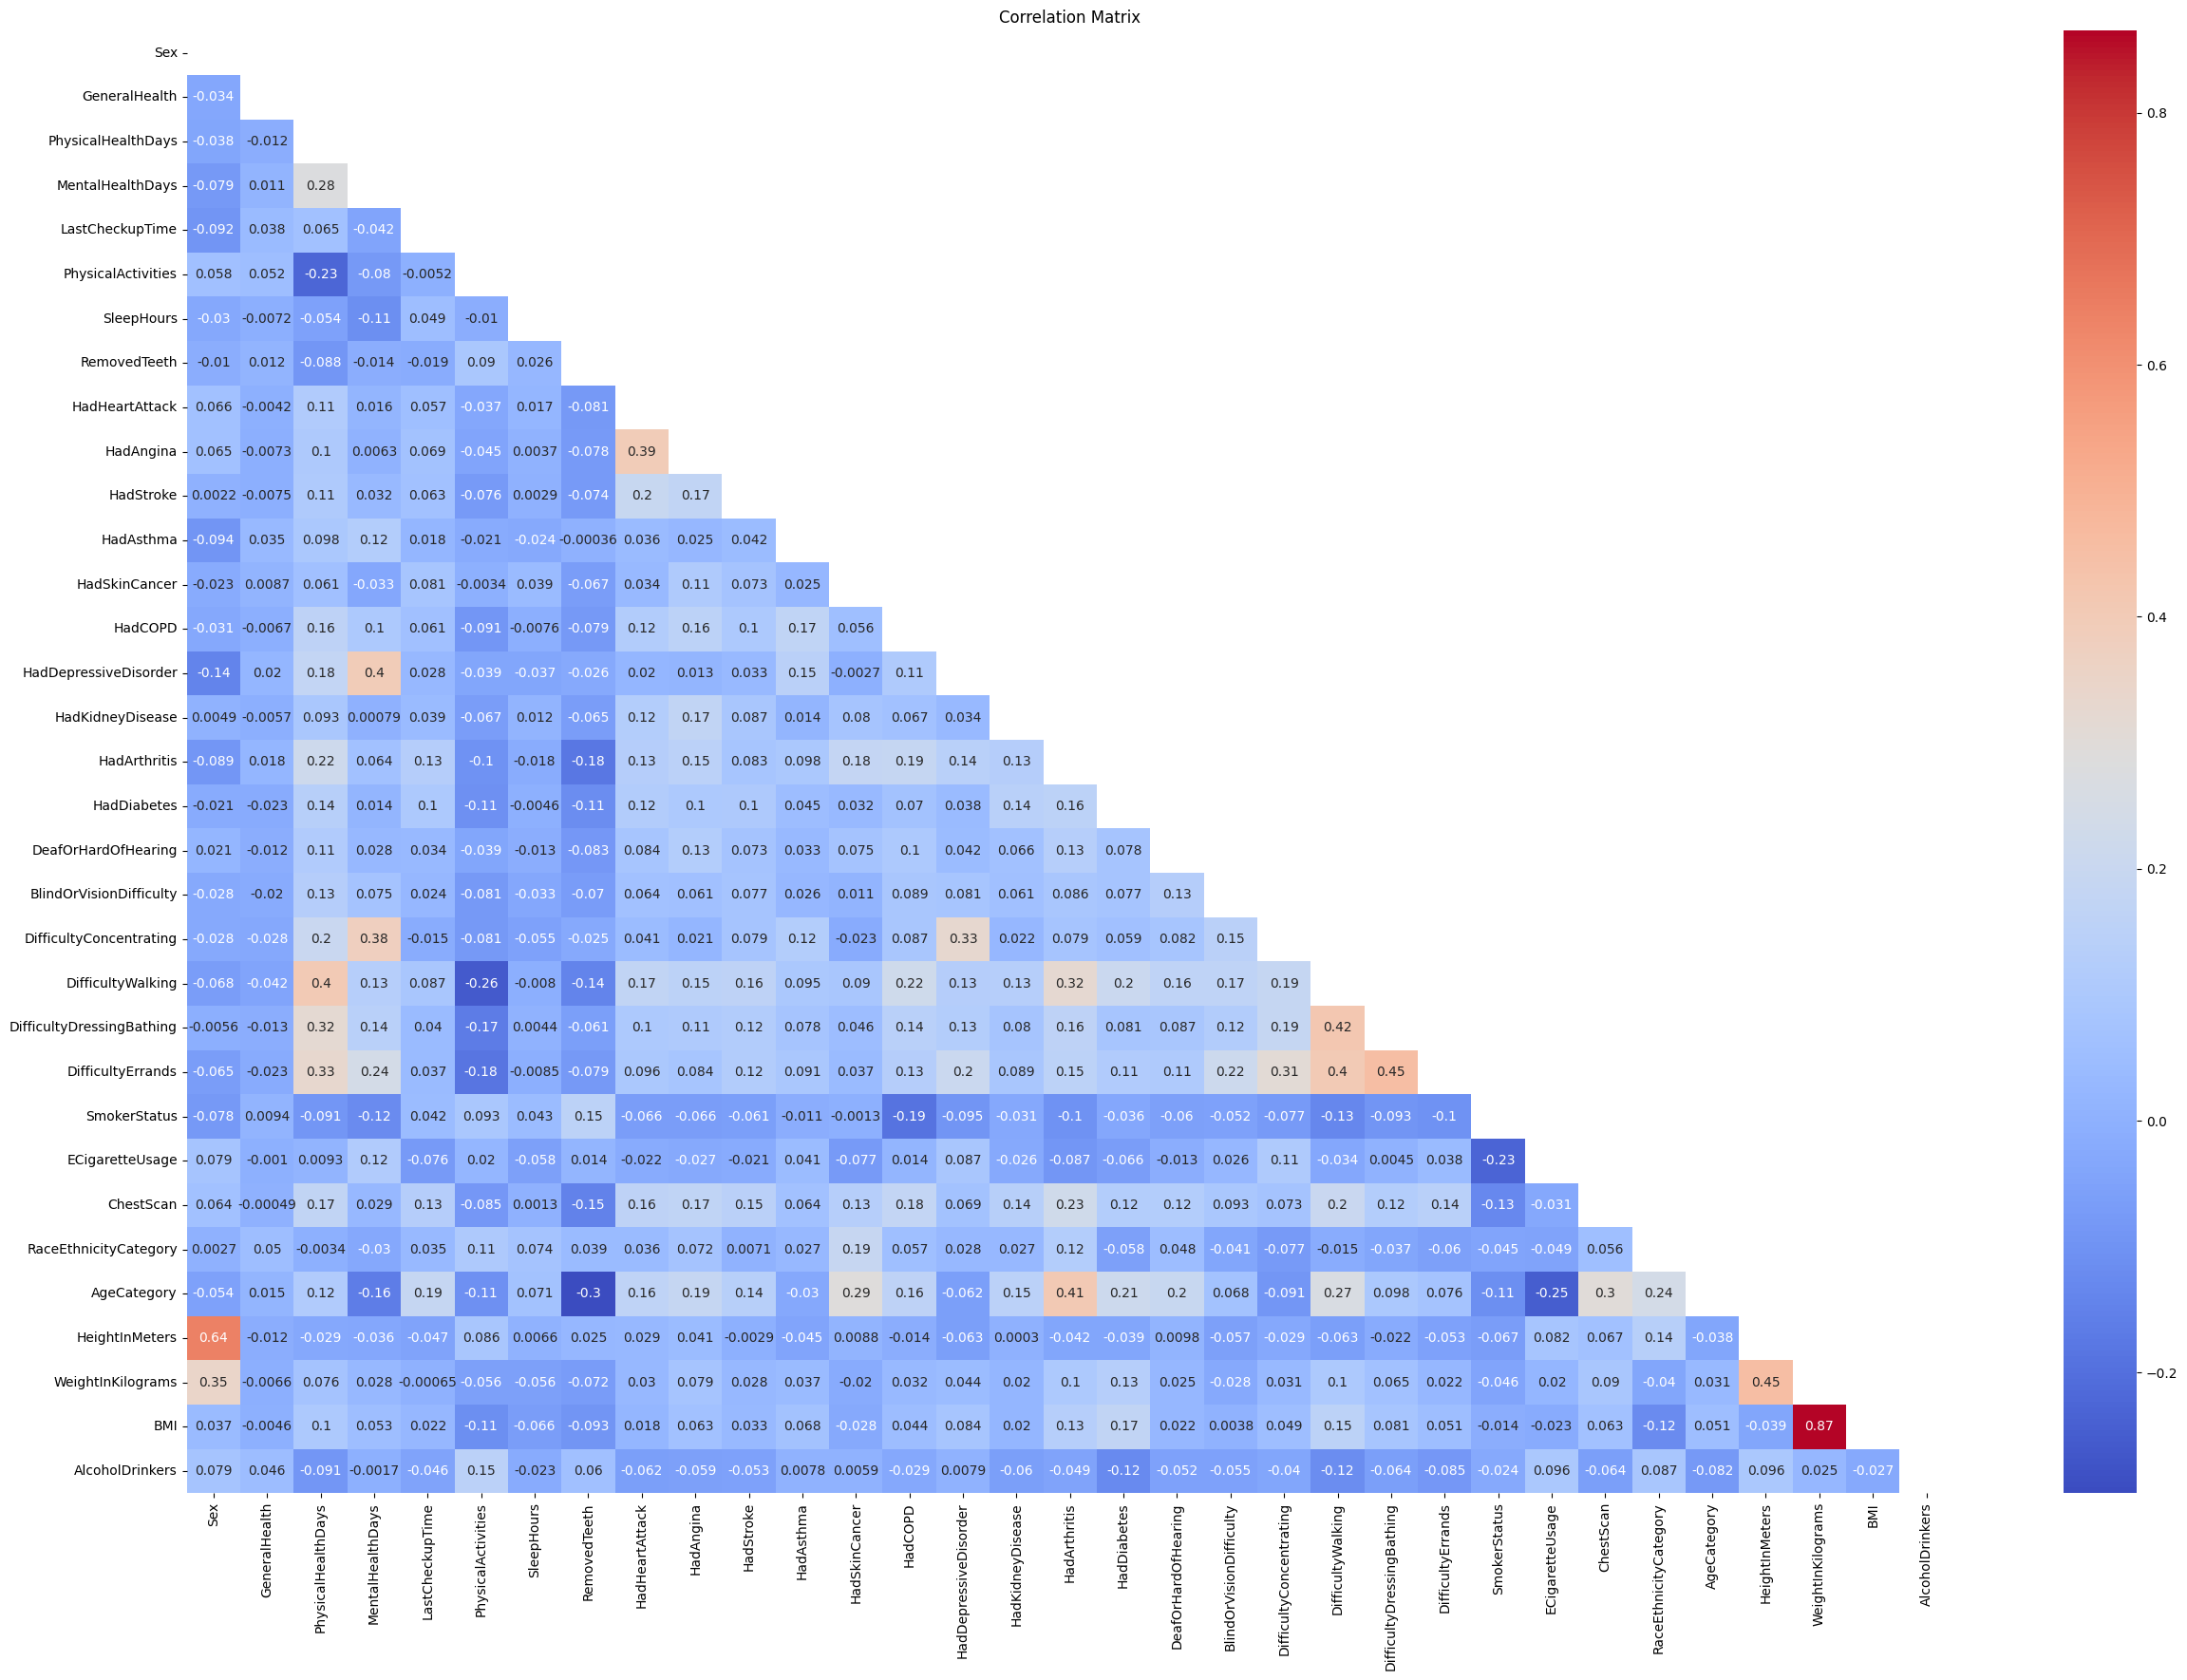

In [4]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Draw heatmap
plt.figure(figsize=(30, 20))

# Create a triangular mask to hide the upper triangle of the heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix as a heatmap
sn.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm')

# Add a title to the plot
plt.title('Correlation Matrix')

# Display the heatmap
plt.show()


**Observations:** Looking at the correlation matrix, we can observe the relationships between variables through the **correlation coefficients**. This provides a general overview of the relationships between columns in the data, which can be helpful for analyzing the following questions.

# **3. Questions**

## Question 1: 

- **Purpose:**
- **How to answer:**

### Preprocessing

### Visualization

### Observation

### **Question 2: What is the overall comparison of general health statuses between males and females across different age groups?**

- **Purpose:** The purpose of asking the question is to understand the overall comparison of general health statuses between males and females across different age groups. This analysis aims to identify any patterns, trends, or disparities in health between genders and age groups.
- **How to answer:** To answer this question, we will extract relevant columns of data such as `Sex`, `GeneralHealth`, and `AgeCategory`. Then, we will group the data by `Sex` and `AgeCategory`, analyze and compare the general health statuses using statistical analysis techniques. The results can be displayed by utilizing appropriate visualizations, and the findings can be explained to draw conclusions and discuss the significance of healthcare policies and interventions.

**1. Preprocessing**
- Step 1: Filter the DataFrame to include only the relevant columns for analysis (`Sex`, `GeneralHealth`, and `AgeCategory`)
- Step 2: Group the data by `Sex` and `AgeCategory` columns, and calculate the count of each health status using the `groupby()` and `value_counts()` functions.

In [11]:
#Filter the DataFrame to include only the relevant columns for analysis
df_health = data[["Sex", "GeneralHealth", "AgeCategory"]]
# Group the data by "Sex" and "AgeCategory" columns, and calculate the count of each health status
health_counts = df_health.groupby(["Sex", "AgeCategory"])["GeneralHealth"].value_counts(normalize = True).unstack().reset_index()

**2. Visualization**

In [14]:
# Filter the data for males and females
male_data = health_counts[health_counts["Sex"] == "Male"]
female_data = health_counts[health_counts["Sex"] == "Female"]

# Define the colors for each health status
colors = ['rgba(31, 119, 180, 0.7)', 'rgba(255, 127, 14, 0.7)', 'rgba(44, 160, 44, 0.7)',
          'rgba(214, 39, 40, 0.7)', 'rgba(148, 103, 189, 0.7)']

# Create subplots for males and females with shared y-axis
fig = make_subplots(rows=1, cols=2, subplot_titles=("Male", "Female"), shared_yaxes=True)

# Plot the stacked bar chart for males
for i, status in enumerate(["Excellent", "Very good", "Good", "Fair", "Poor"]):
    fig.add_trace(go.Bar(x=male_data["AgeCategory"], y=male_data[status], name=status, marker_color=colors[i]), row=1, col=1)

# Plot the stacked bar chart for females
for i, status in enumerate(["Excellent", "Very good", "Good", "Fair", "Poor"]):
    fig.add_trace(go.Bar(x=female_data["AgeCategory"], y=female_data[status], name=status, marker_color=colors[i]), row=1, col=2)

# Customize the legend
fig.update_layout(legend=dict(x=1, y=1, traceorder="normal", bgcolor='rgba(0,0,0,0)'), showlegend=True)

# Customize the layout
fig.update_layout(title="General Health by Gender and Age Group", xaxis_title="Age Category", yaxis_title="Percentage")

# Show the plot
fig.show()

**3. Observation**

- In general, at every age and gender, the proportion of people with good or above-average health remains high.
- Specific analysis:
    - For the age group of 18 to 24: it can be said that this is the age group with the best overall health, with the lowest proportion of poor health.
    - Health status tends to decline over time. In males, from the age of 50 onwards, there is a significant increase in poor health. For females, from the age of 35 onwards, there is a noticeable decline in health.

## **Question 3: Can we predict whether a person has a heart disease based on certain features? Which features can be used to predict whether a person has a heart disease or not?**

- **Purpose:** The purpose of the question is to determine whether it is possible to predict whether a person has a heart disease based on certain features. This question aims to explore the predictive power of the selected features and their relationship to the presence of heart disease.
- **Significance:** Answering this question has several implications. Firstly, it provides insights into the potential of using specific features to predict heart disease. By identifying the most important features, it can help researchers and healthcare professionals understand the underlying factors associated with heart disease. Additionally, the model's accuracy on the test set indicates how well it can generalize to new, unseen data. This information can guide decision-making for healthcare interventions and preventive measures related to heart disease.
- **How to answer:** The methodology involves building a Random Forest model to predict the presence of heart disease using the selected features. The data is split into training and testing sets, and data preprocessing techniques are applied to handle categorical and numeric features. The preprocessed data is then used to train the Random Forest model. Cross-validation is performed to evaluate the model's performance, and the accuracy of the model is measured on the test set.

**1. Preprocessing**

In [9]:
#Selecting features and target variable
categorical_features = ['RemovedTeeth','SmokerStatus','AgeCategory', 'AlcoholDrinkers',
'HadAngina', 'HadStroke', 'HadCOPD', 'HadKidneyDisease',
'HadArthritis', 'HadDiabetes', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'ChestScan']
numeric_features = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'BMI']
target = 'HadHeartAttack'

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), data[target], test_size=0.2, random_state=42)

#Data preprocessing
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

preprocessor = ColumnTransformer(transformers=[
('cat', categorical_transformer, categorical_features),
('num', numeric_transformer, numeric_features)])

#Build the Random Forest model
model = Pipeline(steps=[('preprocessor', preprocessor),
('classifier', RandomForestClassifier())])

#Evaluate the model using Cross Validation
scores = cross_val_score(model, X_train, y_train, cv=5)

print("Accuracy of the model (Cross Validation): {:.2f}% (+/- {:.2f}%)".format(scores.mean() * 100, scores.std() * 100))

#Train the model
model.fit(X_train, y_train)

#Make predictions on the test set
y_pred = model.predict(X_test)

#Evaluate the prediction performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the model on the test set: {:.2f}%".format(accuracy * 100))

Accuracy of the model (Cross Validation): 95.95% (+/- 0.19%)
Accuracy of the model on the test set: 96.41%


**2. Visualization**

In [10]:
#Get the feature importance from the model
importances = model.named_steps['classifier'].feature_importances_
#Get the names of the features
feature_names = categorical_features + numeric_features
#Sort the importances and feature names in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [feature_names[i] for i in indices if i < len(feature_names)]

#Visualize the feature importances
# Define a custom color palette
custom_colors = ['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845']
# Create a bar chart figure with custom colors
fig = go.Figure(data=go.Bar(x= sorted_feature_names, y= sorted_importances, marker=dict(color=custom_colors)))
# Update the layout of the figure
fig.update_layout(
    title='Feature Importance',
    xaxis=dict(title='Features'),
    yaxis=dict(title='Importance')
)
# Show the figure
fig.show()

**3. Observation**

- This chart is used to visualize the feature importances from the model. It shows the importance or contribution of each feature towards the predictions made by the model. The higher the importance value, the more influential the feature is in determining the model's output.
- It can be seen that the feature "HadCOPD" has the highest importance value, followed by "HadKidneyDisease", "AlcoholDrinkers", "RemovedTeeth", "SmokerStatus", and "BMI". The remaining features do not have significantly different importance values.